In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.precision', 2)
#import matplotlib as plt
import matplotlib.pyplot as plt

In [2]:
import keras

EPOCHS               = 50
SAMPLING_FREQ        = 22050
MFCC_COEF_RETAIN     = 25
MFCC_COEF            = 40
MFCC_WINDOW_DURATION = 0.0232 # in miliseconds
OPTIMIZER            = keras.optimizers.Adam()

In [3]:
class_names = ['air_conditioner',
               'car_horn',
               'children_playing',
               'dog_bark','drilling',
               'engine_idling',
               'gun_shot',
               'jackhammer',
               'siren',
               'street_music']

In [4]:
# Load data
sounds_df = pd.read_csv("/Users/jamesjr/Documents/audio_data/UrbanSound8K/metadata/UrbanSound8K.csv")

In [5]:
sounds_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.32,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.50,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.50,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.00,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.50,1,5,2,children_playing


## Data Eploration 

In [6]:
sounds_freq = sounds_df['class'].value_counts().sort_values()
print(sounds_freq)

class
gun_shot             374
car_horn             429
siren                929
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
Name: count, dtype: int64


<Axes: title={'center': 'Sounds'}, ylabel='count'>

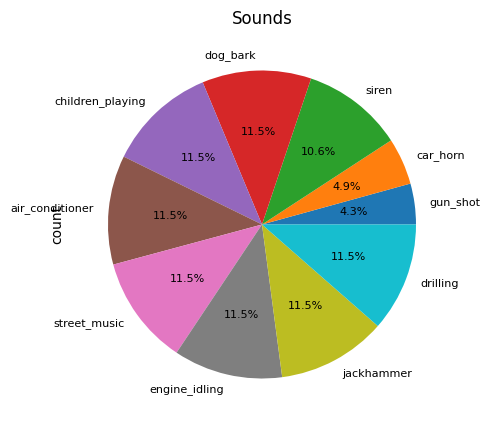

In [7]:
sounds_freq.plot(kind='pie', figsize=(5,5), title='Sounds', autopct='%1.1f%%', shadow = False, fontsize=8)

In [8]:
folds_freq = sounds_df['fold'].value_counts().sort_index()
print(folds_freq)

fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64


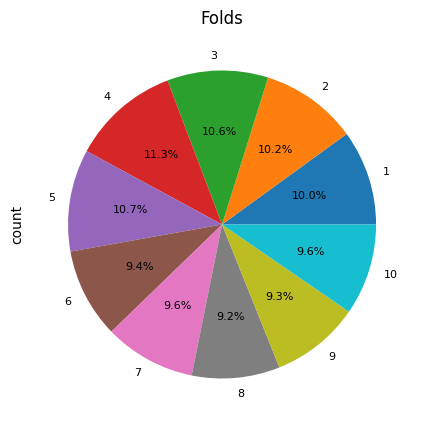

In [9]:
folds_freq.plot(kind='pie', figsize=(5,5), title='Folds', autopct='%1.1f%%', shadow = False, fontsize=8);

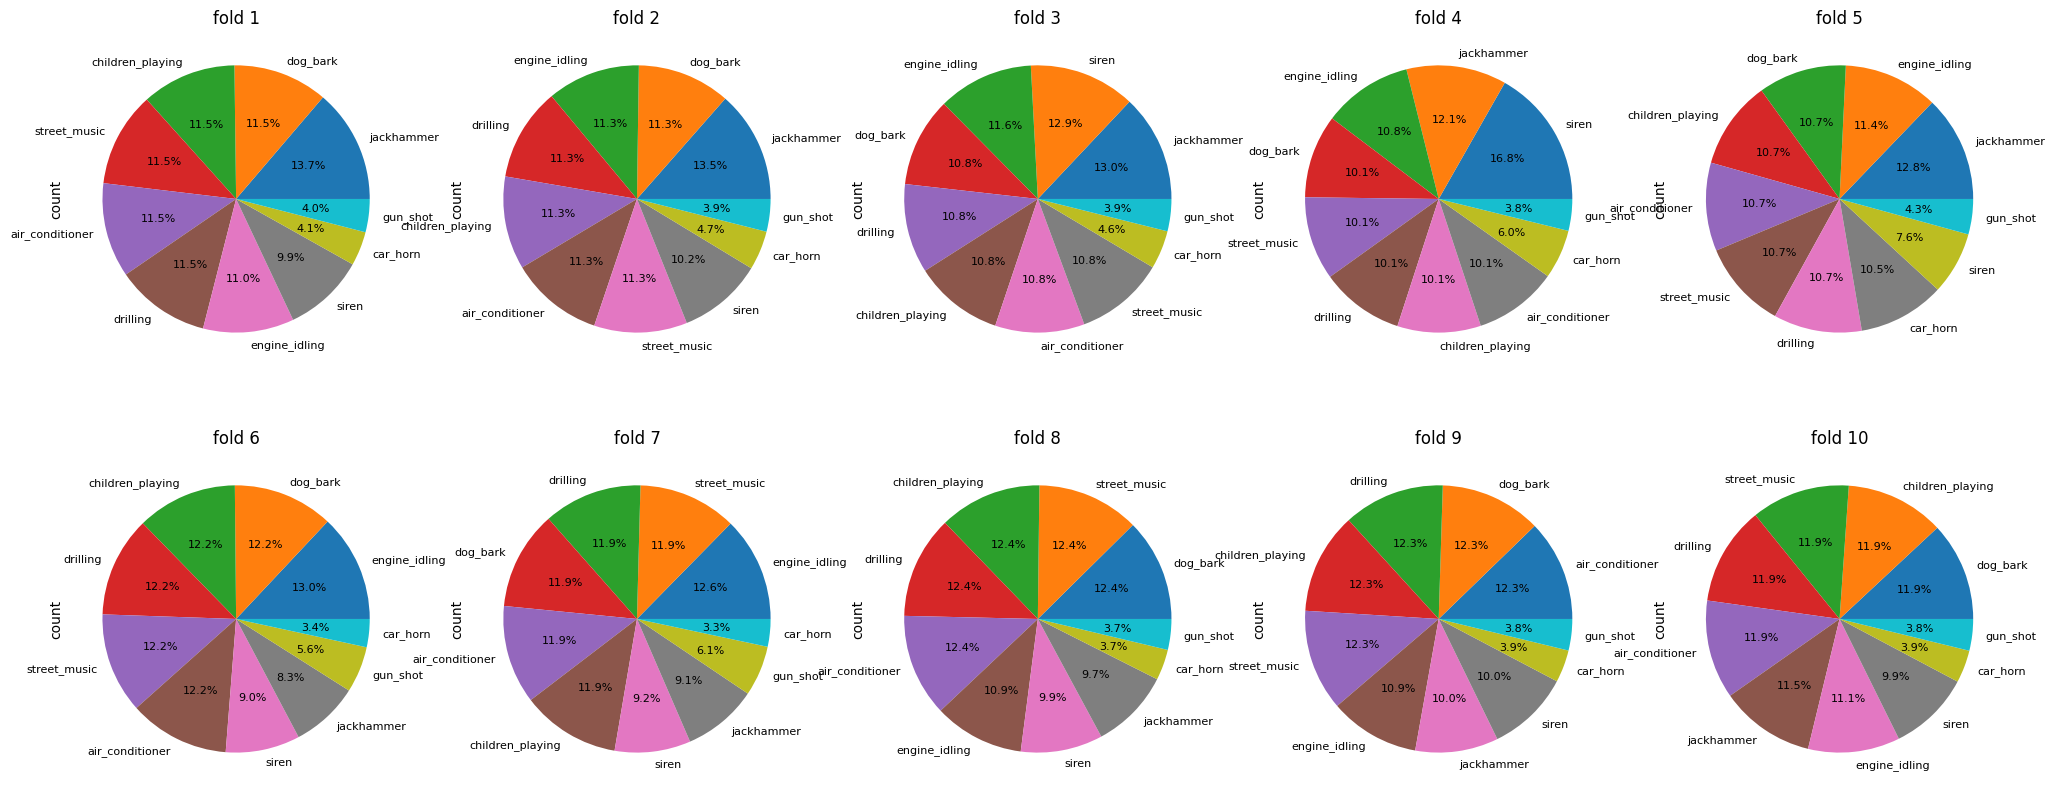

In [10]:
plt.figure(figsize=[25, 10])

for i in range(1,11):
    fold_df = sounds_df[sounds_df['fold'] == i]
    fold_freq = fold_df['class'].value_counts()
    plt.subplot(2, 5, i)
    fold_freq.plot(kind='pie',title=f"fold {i}", autopct='%1.1f%%', shadow = False, fontsize=8)

In [11]:
sounds_df['duration'] = sounds_df['end']-sounds_df['start']

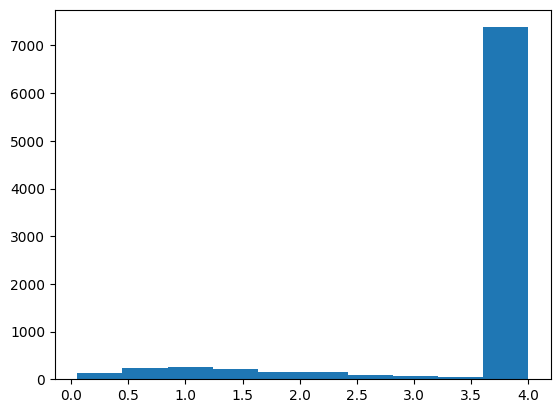

In [12]:
n, bins, patches = plt.hist(sounds_df["duration"], bins=10)

In [13]:
plt.show()

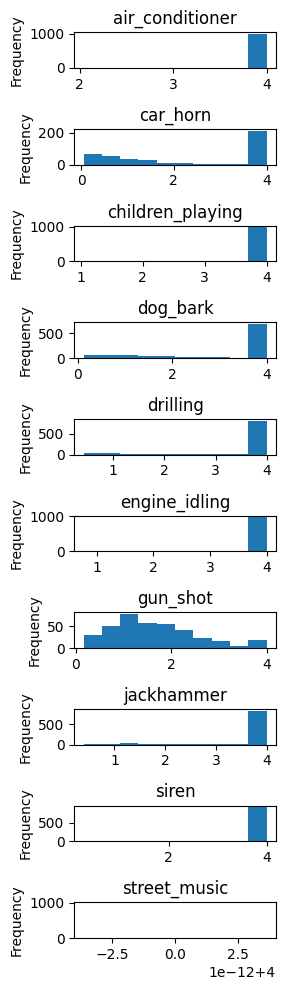

In [14]:
# street_music is always 4s and for some reason the histogram for it is displayed incorrectly!
sounds_df.plot.hist(bins=10, column=["duration"], by="class", figsize=(3, 10), legend=False)
plt.tight_layout()

## Feature Extraction

In [15]:
import librosa
from scipy.stats import skew
from scipy.stats import kurtosis, median_abs_deviation

In [16]:
def get_mfcc(filename, fold):  
    
    # load wav file
    wave, sr = librosa.load(f"/Users/jamesjr/Documents/audio_data/UrbanSound8K/audio/fold{fold}/{filename}", mono=True, sr=SAMPLING_FREQ)
    wave = librosa.util.normalize(wave)
    
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=MFCC_COEF, hop_length=int(MFCC_WINDOW_DURATION*sr/2.0), n_fft=int(MFCC_WINDOW_DURATION*sr)) 
    
    # standardise the coefficients
    mfccs = (mfccs - np.mean(mfccs))/np.std(mfccs)
    
    # keep the first MFCC_COEF_RETAIN coefficients
    mfccs = mfccs[:MFCC_COEF_RETAIN,:]
    
    # calculate MFCC statistics
    mfccs_min      = mfccs.min(axis=1)
    mfccs_max      = mfccs.max(axis=1)
    mfccs_median   = np.median(mfccs, axis=1)
    mfccs_mean     = np.mean(mfccs, axis=1)
    mfccs_var      = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)
    mfccs_mad      = median_abs_deviation(mfccs, axis=1)
    
    mfccs_first_derivative  = np.diff(mfccs, n=1, axis=1)    
    mfccs_first_derivative_mean = np.mean(mfccs_first_derivative, axis=1)
    mfccs_first_derivative_var  = np.var(mfccs_first_derivative, axis=1)
    
    mfccs_second_derivative = np.diff(mfccs, n=2, axis=1)
    mfccs_second_derivative_mean = np.mean(mfccs_second_derivative, axis=1)
    mfccs_second_derivative_var  = np.var(mfccs_second_derivative, axis=1)
    
    mfccs_stats = np.vstack((mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_var, mfccs_skewness, mfccs_kurtosis, mfccs_mad, mfccs_first_derivative_mean, mfccs_first_derivative_var, mfccs_second_derivative_mean, mfccs_second_derivative_var))
    
    return pd.Series([mfccs, mfccs_stats.transpose()])

In [18]:
from tqdm import tqdm

In [19]:
# add MFCCs and statistics to the data frame
tqdm.pandas()
sounds_df[['mfccs','mfccs_stats']]= sounds_df[['slice_file_name', 'fold']].progress_apply(lambda x: get_mfcc(*x), axis=1)

100%|███████████████████████████████████████| 8732/8732 [01:33<00:00, 93.22it/s]


## MFFCs 

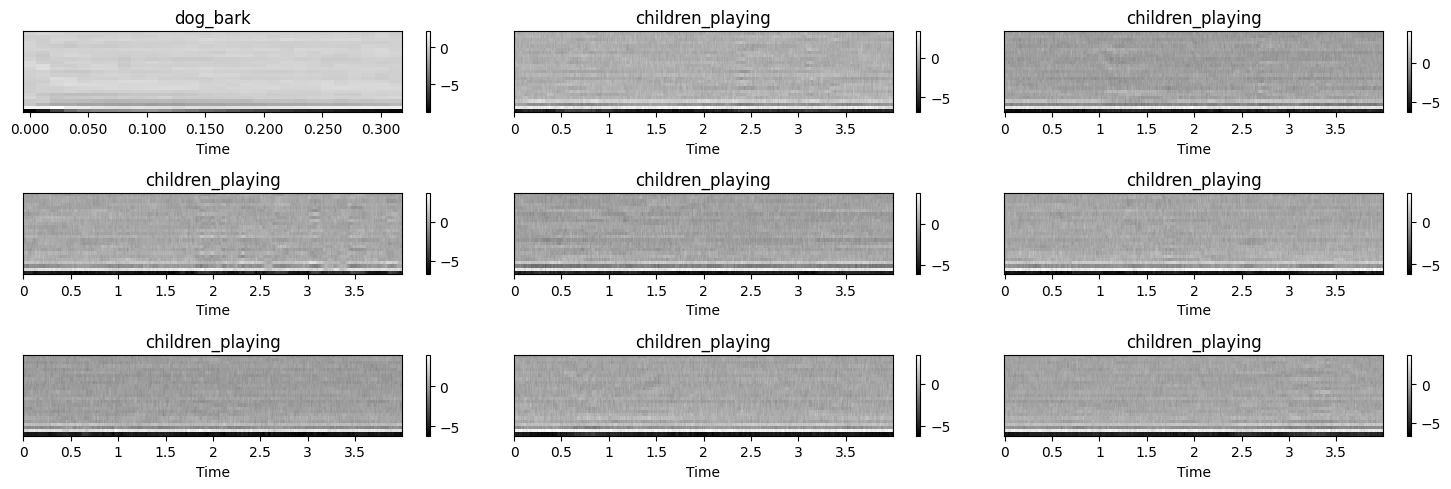

In [20]:
plt.figure(figsize=[15, 5])

for i in range(0,9):
    ax = plt.subplot(3, 3, i+1)
    img = librosa.display.specshow(sounds_df['mfccs'][i], x_axis='time', hop_length=int(0.0232*SAMPLING_FREQ/2.0), cmap='gray')
    ax.set(title=sounds_df['class'][i])
    plt.colorbar()
    
plt.tight_layout()

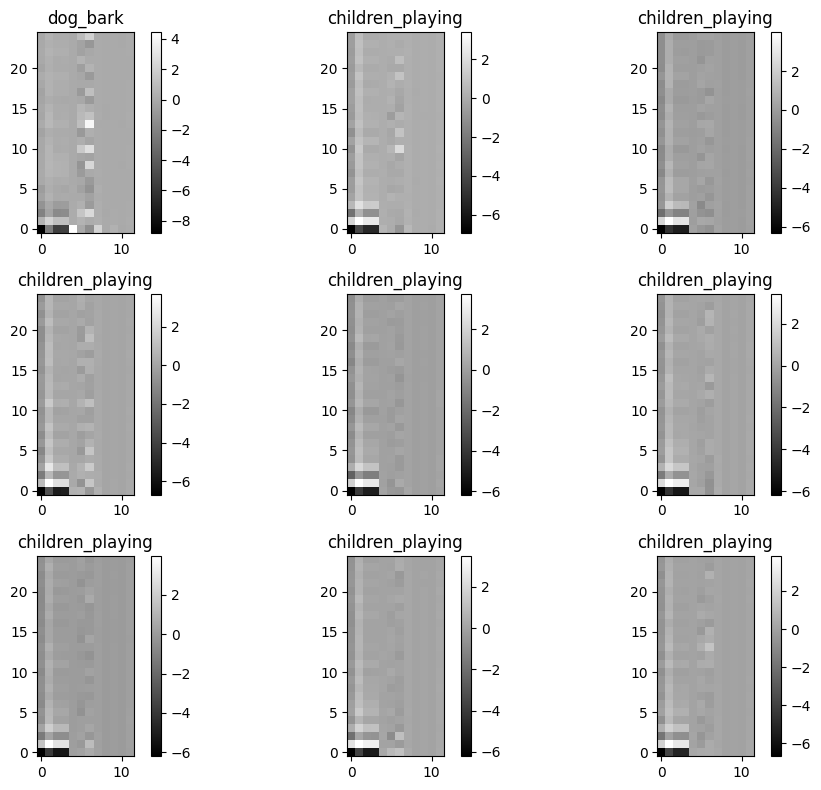

In [21]:
plt.figure(figsize=[10, 8])

for i in range(0,9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow( sounds_df['mfccs_stats'][i], origin='lower', cmap='gray')
    ax.set(title=sounds_df['class'][i])
    plt.colorbar()
    
plt.tight_layout()

Projecting 300-dimensional data to 2D


/var/folders/nw/0q_nkl353854sb49th2b0x8m0000gn/T/ipykernel_56798/3689079774.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


Text(0.5, 1.0, 'PCA projection')

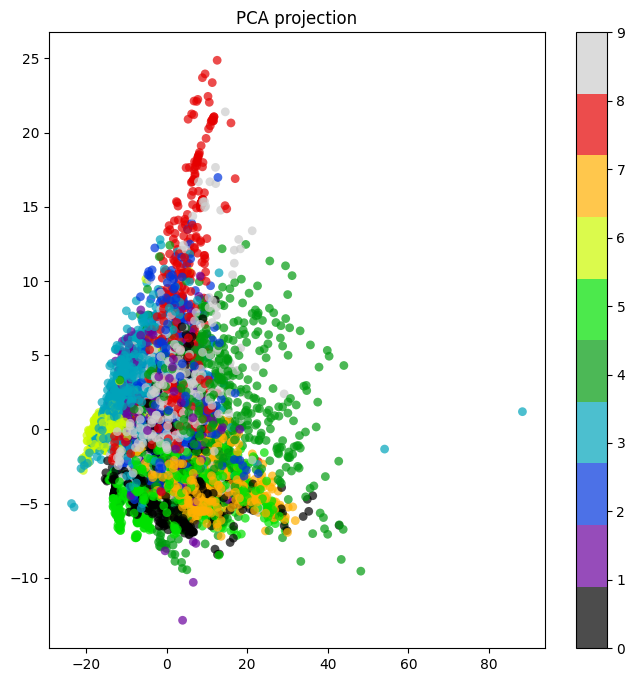

In [22]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

x = np.array(sounds_df['mfccs_stats'].to_list())
x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])

y = np.array(sounds_df['classID'].to_list())
y = y.reshape(y.shape[0], 1)

# standardise data
scale = StandardScaler()
x = scale.fit_transform(x)

pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(x)

print('Projecting %d-dimensional data to 2D' % x.shape[1])

plt.figure(figsize=(8,8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('PCA projection')

In [23]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2)
tsne_model = model.fit_transform(x)

Projecting 300-dimensional data to 2D


/var/folders/nw/0q_nkl353854sb49th2b0x8m0000gn/T/ipykernel_56798/2375387966.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


Text(0.5, 1.0, 't-SNE')

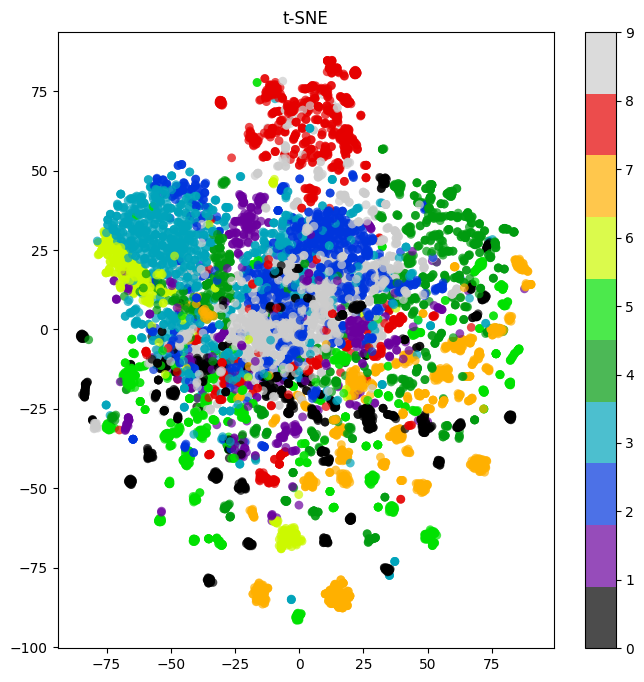

In [24]:
print('Projecting %d-dimensional data to 2D' % x.shape[1])

plt.figure(figsize=(8,8))
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE')

## Utilities 

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

1D CNN ML model for predictions

In [27]:
early = keras.callbacks.EarlyStopping(monitor = 'val_sparse_categorical_accuracy',patience = 10, min_delta = 0.001, restore_best_weights = True)

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D

def get_1d_cnn_model(input_shape, num_classes):
    
    model = Sequential()
    model.add(Conv1D(128, 8, input_shape=input_shape , activation='relu'))
    model.add(Conv1D(64, 4, activation='relu'))
    model.add(Conv1D(32, 2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [29]:
def get_1d_cnn_fold(number, salience):
    
    if salience==0:
        # training set excludes fold number
        train_df = sounds_df[sounds_df['fold'] != number]
        # test set is the fold number
        test_df  = sounds_df[sounds_df['fold'] == number]
    else:
        # training set excludes fold number
        train_df = sounds_df[(sounds_df['fold'] != number) & (sounds_df['salience'] == salience)]
        # test set is the fold number
        test_df  = sounds_df[(sounds_df['fold'] == number) & (sounds_df['salience'] == salience)]
    
    x_train  = np.array(train_df['mfccs_stats'].to_list())
    x_train  = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    
    y_train  = np.array(train_df['classID'].to_list())
    y_train  = y_train.reshape(y_train.shape[0], 1)
      
    x_test  = np.array(test_df['mfccs_stats'].to_list())
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
    
    y_test  = np.array(test_df['classID'].to_list())
    y_test  = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, x_test, y_train, y_test

In [30]:
fold_1d_cnn_history  = []
fold_1d_cnn_accuracy = []

for salience in [2,1,0]:
    print("Salience = ", salience)
    for fold in range(1,11):
        print("Fold = ", fold)
        X_train, X_test, Y_train, Y_test = get_1d_cnn_fold(fold, salience)
        cnn_model = get_1d_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=10)    
        history = cnn_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_test, Y_test), callbacks = [early], verbose=0)
        accuracy_score = cnn_model.evaluate(X_test, Y_test)
        fold_1d_cnn_history.append(history)
        fold_1d_cnn_accuracy.append(accuracy_score)

Salience =  2
Fold =  1
8/8 [==============================] - 0s 910us/step - loss: 1.3153 - sparse_categorical_accuracy: 0.5259


Fold =  2
11/11 [==============================] - 0s 821us/step - loss: 2.7792 - sparse_categorical_accuracy: 0.4515


Fold =  3
11/11 [==============================] - 0s 837us/step - loss: 1.3566 - sparse_categorical_accuracy: 0.5403


Fold =  4
14/14 [==============================] - 0s 780us/step - loss: 1.8743 - sparse_categorical_accuracy: 0.6111


Fold =  5
9/9 [==============================] - 0s 904us/step - loss: 1.1317 - sparse_categorical_accuracy: 0.6374


Fold =  6
10/10 [==============================] - 0s 873us/step - loss: 1.4654 - sparse_categorical_accuracy: 0.5422


Fold =  7
10/10 [==============================] - 0s 866us/step - loss: 1.2102 - sparse_categorical_accuracy: 0.6571


Fold =  8
8/8 [==============================] - 0s 1ms/step - loss: 1.6946 - sparse_categorical_accuracy: 0.5827


Fold =  9
9/9 [==============================] - 0s 1ms/step - loss: 1.6566 - sparse_categorical_accuracy: 0.4624


Fold =  10
9/9 [==============================] - 0s 899us/step - loss: 1.7669 - sparse_categorical_accuracy: 0.4758


Salience =  1
Fold =  1
20/20 [==============================] - 0s 1ms/step - loss: 1.0716 - sparse_categorical_accuracy: 0.7685


Fold =  2
18/18 [==============================] - 0s 939us/step - loss: 0.9657 - sparse_categorical_accuracy: 0.7204


Fold =  3
19/19 [==============================] - 0s 811us/step - loss: 0.9994 - sparse_categorical_accuracy: 0.6831


Fold =  4
18/18 [==============================] - 0s 1ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7133


Fold =  5
21/21 [==============================] - 0s 944us/step - loss: 0.5346 - sparse_categorical_accuracy: 0.7919


Fold =  6
17/17 [==============================] - 0s 670us/step - loss: 0.5780 - sparse_categorical_accuracy: 0.8291


Fold =  7
17/17 [==============================] - 0s 709us/step - loss: 0.4513 - sparse_categorical_accuracy: 0.8612


Fold =  8
18/18 [==============================] - 0s 738us/step - loss: 0.8711 - sparse_categorical_accuracy: 0.7989


Fold =  9
18/18 [==============================] - 0s 915us/step - loss: 0.6047 - sparse_categorical_accuracy: 0.8327


Fold =  10
18/18 [==============================] - 0s 765us/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8310


Salience =  0
Fold =  1
28/28 [==============================] - 0s 808us/step - loss: 0.9289 - sparse_categorical_accuracy: 0.6953


Fold =  2
28/28 [==============================] - 0s 745us/step - loss: 2.1626 - sparse_categorical_accuracy: 0.5923


Fold =  3
29/29 [==============================] - 0s 817us/step - loss: 1.9802 - sparse_categorical_accuracy: 0.5773


Fold =  4
31/31 [==============================] - 0s 716us/step - loss: 0.9822 - sparse_categorical_accuracy: 0.7000


Fold =  5
30/30 [==============================] - 0s 770us/step - loss: 0.7854 - sparse_categorical_accuracy: 0.7415


Fold =  6
26/26 [==============================] - 0s 815us/step - loss: 0.8887 - sparse_categorical_accuracy: 0.7205


Fold =  7
27/27 [==============================] - 0s 829us/step - loss: 0.9170 - sparse_categorical_accuracy: 0.6933


Fold =  8
26/26 [==============================] - 0s 763us/step - loss: 1.0203 - sparse_categorical_accuracy: 0.6935


Fold =  9
26/26 [==============================] - 0s 803us/step - loss: 1.2732 - sparse_categorical_accuracy: 0.7181


Fold =  10
27/27 [==============================] - 0s 689us/step - loss: 0.9610 - sparse_categorical_accuracy: 0.7300


In [31]:
ONE_D_CNN_df = pd.DataFrame(np.array(fold_1d_cnn_accuracy)[:,1].reshape(3,10).transpose()*100,  columns=['1D-CNN_BG', '1D-CNN_FG', '1D-CNN'])
ONE_D_CNN_df

,1D-CNN_BG,1D-CNN_FG,1D-CNN
0,52.59,76.85,69.53
1,45.15,72.04,59.23
2,54.03,68.31,57.73
3,61.11,71.33,70.00
4,63.74,79.19,74.15
5,54.22,82.91,72.05
6,65.71,86.12,69.33
7,58.27,79.89,69.35
8,46.24,83.27,71.81
9,47.58,83.10,73.00


In [32]:
one_d_cnn_test_preds = cnn_model.predict(X_test)
one_d_cnn_test_pred_classes = np.argmax(one_d_cnn_test_preds, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(Y_test, one_d_cnn_test_pred_classes))

27/27 [==============================] - 0s 793us/step
              precision    recall  f1-score   support

           0       0.71      0.85      0.78       100
           1       0.59      0.52      0.55        33
           2       0.65      0.58      0.61       100
           3       0.73      0.80      0.76       100
           4       0.67      0.69      0.68       100
           5       0.86      0.55      0.67        93
           6       0.79      0.94      0.86        32
           7       0.91      0.86      0.89        96
           8       0.76      0.57      0.65        83
           9       0.66      0.91      0.77       100

    accuracy                           0.73       837
   macro avg       0.73      0.73      0.72       837
weighted avg       0.74      0.73      0.73       837



2D CNN

In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def get_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))

    model.add(Flatten())
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [34]:
def get_cnn_fold(number, salience):
    
    if salience==0:
        # training set excludes fold number
        train_df = sounds_df[sounds_df['fold'] != number]
        # test set is the fold number
        test_df  = sounds_df[sounds_df['fold'] == number]
    else:
        # training set excludes fold number
        train_df = sounds_df[(sounds_df['fold'] != number) & (sounds_df['salience'] == salience)]
        # test set is the fold number
        test_df  = sounds_df[(sounds_df['fold'] == number) & (sounds_df['salience'] == salience)]
    
    x_train  = np.array(train_df['mfccs_stats'].to_list())
    x_train  = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    
    y_train  = np.array(train_df['classID'].to_list())
    y_train  = y_train.reshape(y_train.shape[0], 1)
      
    x_test  = np.array(test_df['mfccs_stats'].to_list())
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    
    y_test  = np.array(test_df['classID'].to_list())
    y_test  = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, x_test, y_train, y_test

In [35]:
fold_cnn_history  = []
fold_cnn_accuracy = []

for salience in [2,1,0]:
    print("Salience = ", salience)
    for fold in range(1,11):
        print("Fold = ", fold)
        X_train, X_test, Y_train, Y_test = get_cnn_fold(fold, salience)
        cnn_model = get_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2], 1), num_classes=10)    
        history = cnn_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_test, Y_test), callbacks = [early], verbose=0)
        accuracy_score = cnn_model.evaluate(X_test, Y_test)
        fold_cnn_history.append(history)
        fold_cnn_accuracy.append(accuracy_score)

Salience =  2
Fold =  1
8/8 [==============================] - 0s 2ms/step - loss: 1.7757 - sparse_categorical_accuracy: 0.4821


Fold =  2
11/11 [==============================] - 0s 2ms/step - loss: 2.2119 - sparse_categorical_accuracy: 0.5030


Fold =  3
11/11 [==============================] - 0s 2ms/step - loss: 1.4530 - sparse_categorical_accuracy: 0.5761


Fold =  4
14/14 [==============================] - 0s 2ms/step - loss: 1.9365 - sparse_categorical_accuracy: 0.6296


Fold =  5
9/9 [==============================] - 0s 2ms/step - loss: 0.9957 - sparse_categorical_accuracy: 0.6777


Fold =  6
10/10 [==============================] - 0s 2ms/step - loss: 2.0375 - sparse_categorical_accuracy: 0.5487


Fold =  7
10/10 [==============================] - 0s 2ms/step - loss: 1.2412 - sparse_categorical_accuracy: 0.5833


Fold =  8
8/8 [==============================] - 0s 2ms/step - loss: 1.8299 - sparse_categorical_accuracy: 0.5827


Fold =  9
9/9 [==============================] - 0s 2ms/step - loss: 2.0625 - sparse_categorical_accuracy: 0.5113


Fold =  10
9/9 [==============================] - 0s 2ms/step - loss: 3.1540 - sparse_categorical_accuracy: 0.5167


Salience =  1
Fold =  1
20/20 [==============================] - 0s 2ms/step - loss: 1.4187 - sparse_categorical_accuracy: 0.8071


Fold =  2
18/18 [==============================] - 0s 2ms/step - loss: 0.7533 - sparse_categorical_accuracy: 0.7509


Fold =  3
19/19 [==============================] - 0s 2ms/step - loss: 2.3469 - sparse_categorical_accuracy: 0.6017


Fold =  4
18/18 [==============================] - 0s 2ms/step - loss: 1.0354 - sparse_categorical_accuracy: 0.7384


Fold =  5
21/21 [==============================] - 0s 2ms/step - loss: 0.8071 - sparse_categorical_accuracy: 0.7919


Fold =  6
17/17 [==============================] - 0s 2ms/step - loss: 0.6024 - sparse_categorical_accuracy: 0.8097


Fold =  7
17/17 [==============================] - 0s 2ms/step - loss: 0.5863 - sparse_categorical_accuracy: 0.8403


Fold =  8
18/18 [==============================] - 0s 2ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.8025


Fold =  9
18/18 [==============================] - 0s 2ms/step - loss: 0.5370 - sparse_categorical_accuracy: 0.8491


Fold =  10
18/18 [==============================] - 0s 2ms/step - loss: 0.5224 - sparse_categorical_accuracy: 0.8451


Salience =  0
Fold =  1
28/28 [==============================] - 0s 2ms/step - loss: 1.0000 - sparse_categorical_accuracy: 0.7033


Fold =  2
28/28 [==============================] - 0s 2ms/step - loss: 1.6276 - sparse_categorical_accuracy: 0.6577


Fold =  3
29/29 [==============================] - 0s 2ms/step - loss: 2.4340 - sparse_categorical_accuracy: 0.5784


Fold =  4
31/31 [==============================] - 0s 2ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.6616


Fold =  5
30/30 [==============================] - 0s 2ms/step - loss: 0.8669 - sparse_categorical_accuracy: 0.7511


Fold =  6
26/26 [==============================] - 0s 2ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.6853


Fold =  7
27/27 [==============================] - 0s 2ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.7184


Fold =  8
26/26 [==============================] - 0s 2ms/step - loss: 1.3936 - sparse_categorical_accuracy: 0.6551


Fold =  9
26/26 [==============================] - 0s 2ms/step - loss: 1.2371 - sparse_categorical_accuracy: 0.7292


Fold =  10
27/27 [==============================] - 0s 2ms/step - loss: 0.8633 - sparse_categorical_accuracy: 0.7634


In [36]:
CNN_df = pd.DataFrame(np.array(fold_cnn_accuracy)[:,1].reshape(3,10).transpose()*100,  columns=['2D-CNN_BG', '2D-CNN_FG', '2D-CNN'])
CNN_df

,2D-CNN_BG,2D-CNN_FG,2D-CNN
0,48.21,80.71,70.33
1,50.30,75.09,65.77
2,57.61,60.17,57.84
3,62.96,73.84,66.16
4,67.77,79.19,75.11
5,54.87,80.97,68.53
6,58.33,84.03,71.84
7,58.27,80.25,65.51
8,51.13,84.91,72.92
9,51.67,84.51,76.34


In [37]:
cnn_test_preds = cnn_model.predict(X_test)
cnn_test_pred_classes = np.argmax(cnn_test_preds, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(Y_test, cnn_test_pred_classes))

27/27 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.89      0.79       100
           1       0.95      0.61      0.74        33
           2       0.67      0.64      0.65       100
           3       0.65      0.74      0.69       100
           4       0.86      0.64      0.74       100
           5       0.74      0.80      0.77        93
           6       0.86      0.94      0.90        32
           7       0.94      0.93      0.93        96
           8       0.71      0.61      0.66        83
           9       0.79      0.84      0.81       100

    accuracy                           0.76       837
   macro avg       0.79      0.76      0.77       837
weighted avg       0.77      0.76      0.76       837



Deep Neural Network 

In [38]:
from sklearn.preprocessing import StandardScaler

def get_dnn_fold(number, salience):
    
    if salience==0:
        # training set excludes fold number
        train_df = sounds_df[sounds_df['fold'] != number]
        # test set is the fold number
        test_df  = sounds_df[sounds_df['fold'] == number]
    else:
        # training set excludes fold number
        train_df = sounds_df[(sounds_df['fold'] != number) & (sounds_df['salience'] == salience)]
        # test set is the fold number
        test_df  = sounds_df[(sounds_df['fold'] == number) & (sounds_df['salience'] == salience)]
    
    x_train  = np.array(train_df['mfccs_stats'].to_list())
    x_train  = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
    
    y_train  = np.array(train_df['classID'].to_list())
    y_train  = y_train.reshape(y_train.shape[0], 1)
    
    x_test  = np.array(test_df['mfccs_stats'].to_list())
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
    
    y_test  = np.array(test_df['classID'].to_list())
    y_test  = y_test.reshape(y_test.shape[0], 1)
    
    # standardise data based on training data and do not include test data
    scale = StandardScaler()
    x_train = scale.fit_transform(x_train)
    x_test = scale.transform(x_test)
    
    return x_train, x_test, y_train, y_test

In [39]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def get_dnn_model(num_classes):
    model = Sequential()
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.10))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [40]:
fold_dnn_history  = []
fold_dnn_accuracy = []

for salience in [2,1,0]:
    print("Salience = ", salience) 
    for fold in range(1,11):   
        print("Fold = ", fold)    
        X_train, X_test, Y_train, Y_test = get_dnn_fold(fold, salience) 
        dnn_model = get_dnn_model(num_classes=10)  
        history = dnn_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_test, Y_test), callbacks = [early], verbose=0)  
        accuracy_score = dnn_model.evaluate(X_test, Y_test)   
        fold_dnn_history.append(history)
        fold_dnn_accuracy.append(accuracy_score)

Salience =  2
Fold =  1
8/8 [==============================] - 0s 722us/step - loss: 1.5135 - sparse_categorical_accuracy: 0.4781


Fold =  2
11/11 [==============================] - 0s 781us/step - loss: 1.5630 - sparse_categorical_accuracy: 0.4727


Fold =  3
11/11 [==============================] - 0s 612us/step - loss: 1.6897 - sparse_categorical_accuracy: 0.5761


Fold =  4
14/14 [==============================] - 0s 670us/step - loss: 1.1919 - sparse_categorical_accuracy: 0.6481


Fold =  5
9/9 [==============================] - 0s 691us/step - loss: 1.0795 - sparse_categorical_accuracy: 0.7070


Fold =  6
10/10 [==============================] - 0s 670us/step - loss: 1.3950 - sparse_categorical_accuracy: 0.5000


Fold =  7
10/10 [==============================] - 0s 739us/step - loss: 1.3209 - sparse_categorical_accuracy: 0.5769


Fold =  8
8/8 [==============================] - 0s 698us/step - loss: 1.7010 - sparse_categorical_accuracy: 0.6457


Fold =  9
9/9 [==============================] - 0s 705us/step - loss: 1.9917 - sparse_categorical_accuracy: 0.4662


Fold =  10
9/9 [==============================] - 0s 648us/step - loss: 1.7070 - sparse_categorical_accuracy: 0.5836


Salience =  1
Fold =  1
20/20 [==============================] - 0s 429us/step - loss: 0.8864 - sparse_categorical_accuracy: 0.7910


Fold =  2
18/18 [==============================] - 0s 480us/step - loss: 0.8104 - sparse_categorical_accuracy: 0.7688


Fold =  3
19/19 [==============================] - 0s 522us/step - loss: 1.3466 - sparse_categorical_accuracy: 0.6085


Fold =  4
18/18 [==============================] - 0s 454us/step - loss: 0.9605 - sparse_categorical_accuracy: 0.7384


Fold =  5
21/21 [==============================] - 0s 469us/step - loss: 0.9145 - sparse_categorical_accuracy: 0.7934


Fold =  6
17/17 [==============================] - 0s 546us/step - loss: 0.9184 - sparse_categorical_accuracy: 0.8252


Fold =  7
17/17 [==============================] - 0s 508us/step - loss: 0.7437 - sparse_categorical_accuracy: 0.8061


Fold =  8
18/18 [==============================] - 0s 602us/step - loss: 0.6436 - sparse_categorical_accuracy: 0.8496


Fold =  9
18/18 [==============================] - 0s 593us/step - loss: 0.5125 - sparse_categorical_accuracy: 0.8236


Fold =  10
18/18 [==============================] - 0s 508us/step - loss: 0.4856 - sparse_categorical_accuracy: 0.8644


Salience =  0
Fold =  1
28/28 [==============================] - 0s 461us/step - loss: 1.0344 - sparse_categorical_accuracy: 0.6804


Fold =  2
28/28 [==============================] - 0s 442us/step - loss: 1.1339 - sparse_categorical_accuracy: 0.6498


Fold =  3
29/29 [==============================] - 0s 471us/step - loss: 2.0828 - sparse_categorical_accuracy: 0.5632


Fold =  4
31/31 [==============================] - 0s 491us/step - loss: 1.0423 - sparse_categorical_accuracy: 0.6990


Fold =  5
30/30 [==============================] - 0s 493us/step - loss: 0.7887 - sparse_categorical_accuracy: 0.7724


Fold =  6
26/26 [==============================] - 0s 457us/step - loss: 1.0647 - sparse_categorical_accuracy: 0.6926


Fold =  7
27/27 [==============================] - 0s 449us/step - loss: 0.9516 - sparse_categorical_accuracy: 0.7267


Fold =  8
26/26 [==============================] - 0s 460us/step - loss: 1.3598 - sparse_categorical_accuracy: 0.7258


Fold =  9
26/26 [==============================] - 0s 452us/step - loss: 1.3506 - sparse_categorical_accuracy: 0.7132


Fold =  10
27/27 [==============================] - 0s 442us/step - loss: 0.9053 - sparse_categorical_accuracy: 0.7431


In [41]:
DNN_df = pd.DataFrame(np.array(fold_dnn_accuracy)[:,1].reshape(3,10).transpose()*100,  columns=['DNN_BG', 'DNN_FG', 'DNN'])
DNN_df

,DNN_BG,DNN_FG,DNN
0,47.81,79.10,68.04
1,47.27,76.88,64.98
2,57.61,60.85,56.32
3,64.81,73.84,69.90
4,70.70,79.34,77.24
5,50.00,82.52,69.26
6,57.69,80.61,72.67
7,64.57,84.96,72.58
8,46.62,82.36,71.32
9,58.36,86.44,74.31


In [42]:
dnn_test_preds = dnn_model.predict(X_test)
dnn_test_pred_classes = np.argmax(dnn_test_preds, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(Y_test, dnn_test_pred_classes))

27/27 [==============================] - 0s 588us/step
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       100
           1       1.00      0.58      0.73        33
           2       0.55      0.72      0.62       100
           3       0.79      0.77      0.78       100
           4       0.73      0.77      0.75       100
           5       0.80      0.74      0.77        93
           6       0.86      0.94      0.90        32
           7       0.88      0.80      0.84        96
           8       0.66      0.59      0.62        83
           9       0.77      0.83      0.80       100

    accuracy                           0.74       837
   macro avg       0.78      0.74      0.75       837
weighted avg       0.76      0.74      0.74       837



## LSTM 

In [43]:
def get_lstm_fold(number, salience):
 
    if salience==0:
        # training set excludes fold number
        train_df = sounds_df[sounds_df['fold'] != number]
        # test set is the fold number
        test_df  = sounds_df[sounds_df['fold'] == number]
    else:
        # training set excludes fold number
        train_df = sounds_df[(sounds_df['fold'] != number) & (sounds_df['salience'] == salience)]
        # test set is the fold number
        test_df  = sounds_df[(sounds_df['fold'] == number) & (sounds_df['salience'] == salience)]
    
    x_train  = np.array(train_df['mfccs_stats'].to_list())
    x_train  = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
    
    y_train  = np.array(train_df['classID'].to_list())
    y_train  = y_train.reshape(y_train.shape[0], 1)
    
    x_test  = np.array(test_df['mfccs_stats'].to_list())
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
    
    y_test  = np.array(test_df['classID'].to_list())
    y_test  = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, x_test, y_train, y_test

In [44]:
def get_lstm_model(num_classes):
    
    model = keras.Sequential([keras.layers.LSTM(256, return_sequences=False),
                              keras.layers.BatchNormalization(),
                              keras.layers.Dropout(0.4),
                              keras.layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

    return model

In [45]:
fold_lstm_history  = []
fold_lstm_accuracy = []

for salience in [2,1,0]:
    print("Salience = ", salience) 
    for fold in range(1,11):    
        print("Fold = ", fold)    
        X_train, X_test, Y_train, Y_test = get_lstm_fold(fold, salience)   
        lstm_model = get_lstm_model(num_classes=10)   
        history = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(X_test, Y_test), callbacks = [early], verbose=0) 
        accuracy_score = lstm_model.evaluate(X_test, Y_test)    
        fold_lstm_history.append(history)
        fold_lstm_accuracy.append(accuracy_score)

Salience =  2
Fold =  1
8/8 [==============================] - 0s 8ms/step - loss: 1.6422 - sparse_categorical_accuracy: 0.5060


Fold =  2
11/11 [==============================] - 0s 8ms/step - loss: 1.4106 - sparse_categorical_accuracy: 0.5758


Fold =  3
11/11 [==============================] - 0s 7ms/step - loss: 1.6669 - sparse_categorical_accuracy: 0.4955


Fold =  4
14/14 [==============================] - 0s 7ms/step - loss: 1.6244 - sparse_categorical_accuracy: 0.6042


Fold =  5
9/9 [==============================] - 0s 6ms/step - loss: 1.5244 - sparse_categorical_accuracy: 0.5897


Fold =  6
10/10 [==============================] - 0s 7ms/step - loss: 1.6519 - sparse_categorical_accuracy: 0.5519


Fold =  7
10/10 [==============================] - 0s 6ms/step - loss: 1.5451 - sparse_categorical_accuracy: 0.4968


Fold =  8
8/8 [==============================] - 0s 7ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.5709


Fold =  9
9/9 [==============================] - 0s 7ms/step - loss: 1.6866 - sparse_categorical_accuracy: 0.5075


Fold =  10
9/9 [==============================] - 0s 7ms/step - loss: 2.2876 - sparse_categorical_accuracy: 0.4907


Salience =  1
Fold =  1
20/20 [==============================] - 0s 6ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.8312


Fold =  2
18/18 [==============================] - 0s 8ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.7473


Fold =  3
19/19 [==============================] - 0s 6ms/step - loss: 1.9969 - sparse_categorical_accuracy: 0.6186


Fold =  4
18/18 [==============================] - 0s 6ms/step - loss: 0.8480 - sparse_categorical_accuracy: 0.7276


Fold =  5
21/21 [==============================] - 0s 6ms/step - loss: 1.0449 - sparse_categorical_accuracy: 0.7466


Fold =  6
17/17 [==============================] - 0s 6ms/step - loss: 0.7409 - sparse_categorical_accuracy: 0.8117


Fold =  7
17/17 [==============================] - 0s 6ms/step - loss: 0.6873 - sparse_categorical_accuracy: 0.8004


Fold =  8
18/18 [==============================] - 0s 6ms/step - loss: 0.7995 - sparse_categorical_accuracy: 0.7192


Fold =  9
18/18 [==============================] - 0s 6ms/step - loss: 0.5479 - sparse_categorical_accuracy: 0.8473


Fold =  10
18/18 [==============================] - 0s 6ms/step - loss: 0.6095 - sparse_categorical_accuracy: 0.8662


Salience =  0
Fold =  1
28/28 [==============================] - 0s 6ms/step - loss: 0.9320 - sparse_categorical_accuracy: 0.7308


Fold =  2
28/28 [==============================] - 0s 6ms/step - loss: 1.2811 - sparse_categorical_accuracy: 0.6622


Fold =  3
29/29 [==============================] - 0s 6ms/step - loss: 1.8926 - sparse_categorical_accuracy: 0.5697
Fold =  4


31/31 [==============================] - 0s 6ms/step - loss: 1.0488 - sparse_categorical_accuracy: 0.7061


Fold =  5
30/30 [==============================] - 0s 6ms/step - loss: 0.8238 - sparse_categorical_accuracy: 0.7853
Fold =  6


26/26 [==============================] - 0s 7ms/step - loss: 1.2255 - sparse_categorical_accuracy: 0.7023


Fold =  7
27/27 [==============================] - 0s 6ms/step - loss: 1.0653 - sparse_categorical_accuracy: 0.6921


Fold =  8
26/26 [==============================] - 0s 6ms/step - loss: 1.2464 - sparse_categorical_accuracy: 0.6774


Fold =  9
26/26 [==============================] - 0s 6ms/step - loss: 1.0411 - sparse_categorical_accuracy: 0.7721


Fold =  10
27/27 [==============================] - 0s 5ms/step - loss: 0.9089 - sparse_categorical_accuracy: 0.7419


In [46]:
LSTM_df = pd.DataFrame(np.array(fold_lstm_accuracy)[:,1].reshape(3,10).transpose()*100,  columns=['LSTM_BG', 'LSTM_FG', 'LSTM'])
LSTM_df

,LSTM_BG,LSTM_FG,LSTM
0,50.60,83.12,73.08
1,57.58,74.73,66.22
2,49.55,61.86,56.97
3,60.42,72.76,70.61
4,58.97,74.66,78.53
5,55.19,81.17,70.23
6,49.68,80.04,69.21
7,57.09,71.92,67.74
8,50.75,84.73,77.21
9,49.07,86.62,74.19
